# Importing Libraries

In [1]:
# Basic Libraries
import os
import datetime as dt

# Data Manipulation Libraries
import numpy as np 
import pandas as pd 

# Data Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning Libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Machine Learning Models
from sklearn.linear_model import LogisticRegression  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE

# Statistics
from scipy.stats import mannwhitneyu

# Defining Packages

In [2]:
def cohen_d(group1, group2):
    mean_diff = group1.mean() - group2.mean()
    pooled_std = ((group1.std()**2 + group2.std()**2) / 2)**0.5
    return mean_diff / pooled_std

In [3]:
def mean_comp(df, feature):
    sat = round(df[df['satisfaction']=='satisfied'][feature].mean(),2)
    dsat = round(df[df['satisfaction']=='dissatisfied'][feature].mean(),2)
    print(feature)
    print(f"Satisfied:\t{sat}")
    print(f"Dissatisfied:\t{dsat}\t Diff: {round(sat-dsat,2)}")

In [4]:
def plot_features_bar(df, ft, huex, palettex, num_cols=4):
    
    dfx = df[ft]

    # Calculate the number of rows and columns needed
    num_plots = len(ft)
    num_rows = -(-num_plots // num_cols)  # Ceiling division to determine the number of rows

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    # Flatten axes if there's only one row
    axes = axes.flatten() if num_rows == 1 else axes
    
    max_count = df[ft].apply(lambda col: col.value_counts().max()).max()

    # Plot each numerical/rate column
    for i, rat in enumerate(ft):
        plt.subplot(num_rows, num_cols, i+1)
        sns.countplot(data=df, 
                      x=rat, 
                      hue=huex, 
                      palette=palettex)

        # Setting the title, labels, and rotation for the x-axis ticks on a plot
        plt.title('Distribution of {}'.format(rat))
        plt.xlabel('Rating')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        plt.ylim(0, max_count)

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

In [5]:
def plot_violin(df, varX, varY, varClass, palettex):

    plt.figure(figsize=(10, 6))

    # Create a violin plot
    sns.violinplot(x=varX, y=varY, data=df, hue=varClass, palette=palettex)

    # Add labels and title
    plt.xlabel(varX)
    plt.ylabel(varY)
    plt.title(f"{varX} vs {varY} across {varClass}")

    # Show the plot
    plt.show()

# Data Load

In [6]:
cwd = os.path.abspath('')
cwd_data = cwd + '/Invistico_Airline.csv'

In [7]:
df = pd.read_csv(cwd_data)

In [8]:
df.head(5)

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0


# Data Description

In [9]:
df.shape

(129880, 22)

## Column Names & Types

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Customer Type                      129880 non-null  object 
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  object 
 4   Class                              129880 non-null  object 
 5   Flight Distance                    129880 non-null  int64  
 6   Seat comfort                       129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Food and drink                     129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Inflight wifi service              129880 non-null  int64  
 11  Inflight entertainment             1298

## Duplicates

In [11]:
df.duplicated().sum()

0

## NULL Values

In [12]:
df.isnull().sum()

satisfaction                           0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Seat comfort                           0
Departure/Arrival time convenient      0
Food and drink                         0
Gate location                          0
Inflight wifi service                  0
Inflight entertainment                 0
Online support                         0
Ease of Online booking                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Cleanliness                            0
Online boarding                        0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
dtype: int64

# Feature Examination - Categorical

In [13]:
# Splitting features into Categorical (catg) and Numerical (numr)

col_catg = []
col_numr = []

for col in df.columns.tolist():
    if df[col].dtype == object:
        col_catg.append(col)
    else:
        col_numr.append(col)

## Distributions

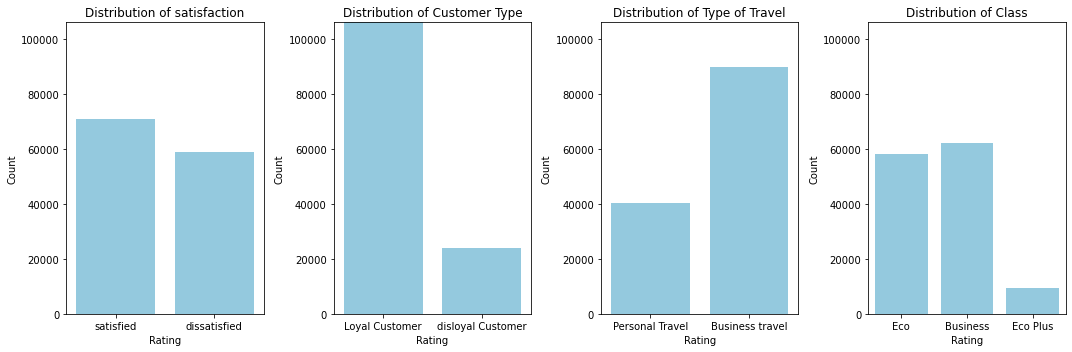

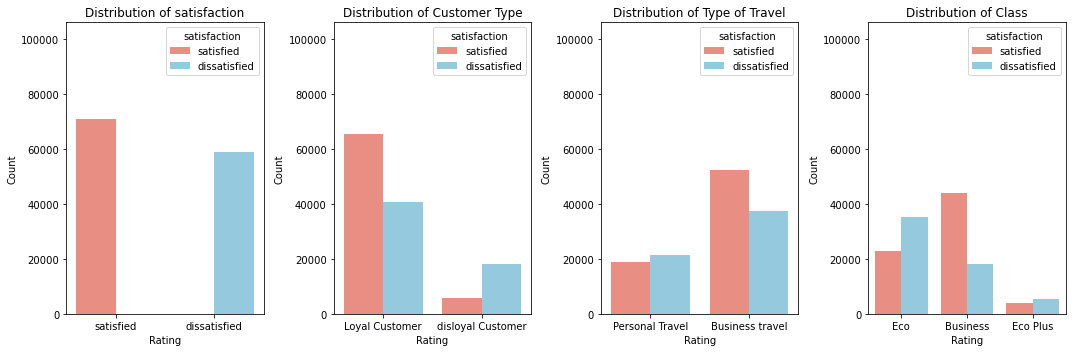

In [14]:
plot_features_bar(df, col_catg, None, ['skyblue'], 4)
plot_features_bar(df, col_catg, 'satisfaction', ['salmon', 'skyblue'], 4)

#### Distributions

Satisfaction Distribution:
- The distribution between satisfied and dissatisfied customers is fairly balanced, which is beneficial for model training.

Customer Type:
- There is an imbalance in the distribution between Loyal and Disloyal customers, with more data for Loyal Customers. Despite this, there is a clear distinction in satisfaction levels between the two groups.
- Loyal customers tend to be satisfied compared to Disloyal customers.

Travel Type:
- There are more observations for Business Travel than Personal Travel. Satisfaction levels show a notable trend, with Business Travel having a higher proportion of satisfied customers. Customers travelling for Business purposes tend to be satisfied compared to customers travelling for Personal reasons - which errs slightly towards dissatisfaction.

Class Distribution:
- A polarity exists between customers travelling on Economy and Business. Customers on Economy are more likely to be dissatisfied compared to those on Business class. Customers on Economy Plus, despite being a small group, exhibits a slightly higher proportion of dissatisfied customers, similar to Economy customers.

# Feature Examination - Numerical

In [15]:
# Separating rating features from non-rating features

col_numr_nonrate = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

col_numr_rate = col_numr.copy()

for rem in col_numr_nonrate:
    col_numr_rate.remove(rem)

## Rating Features

### Distributions

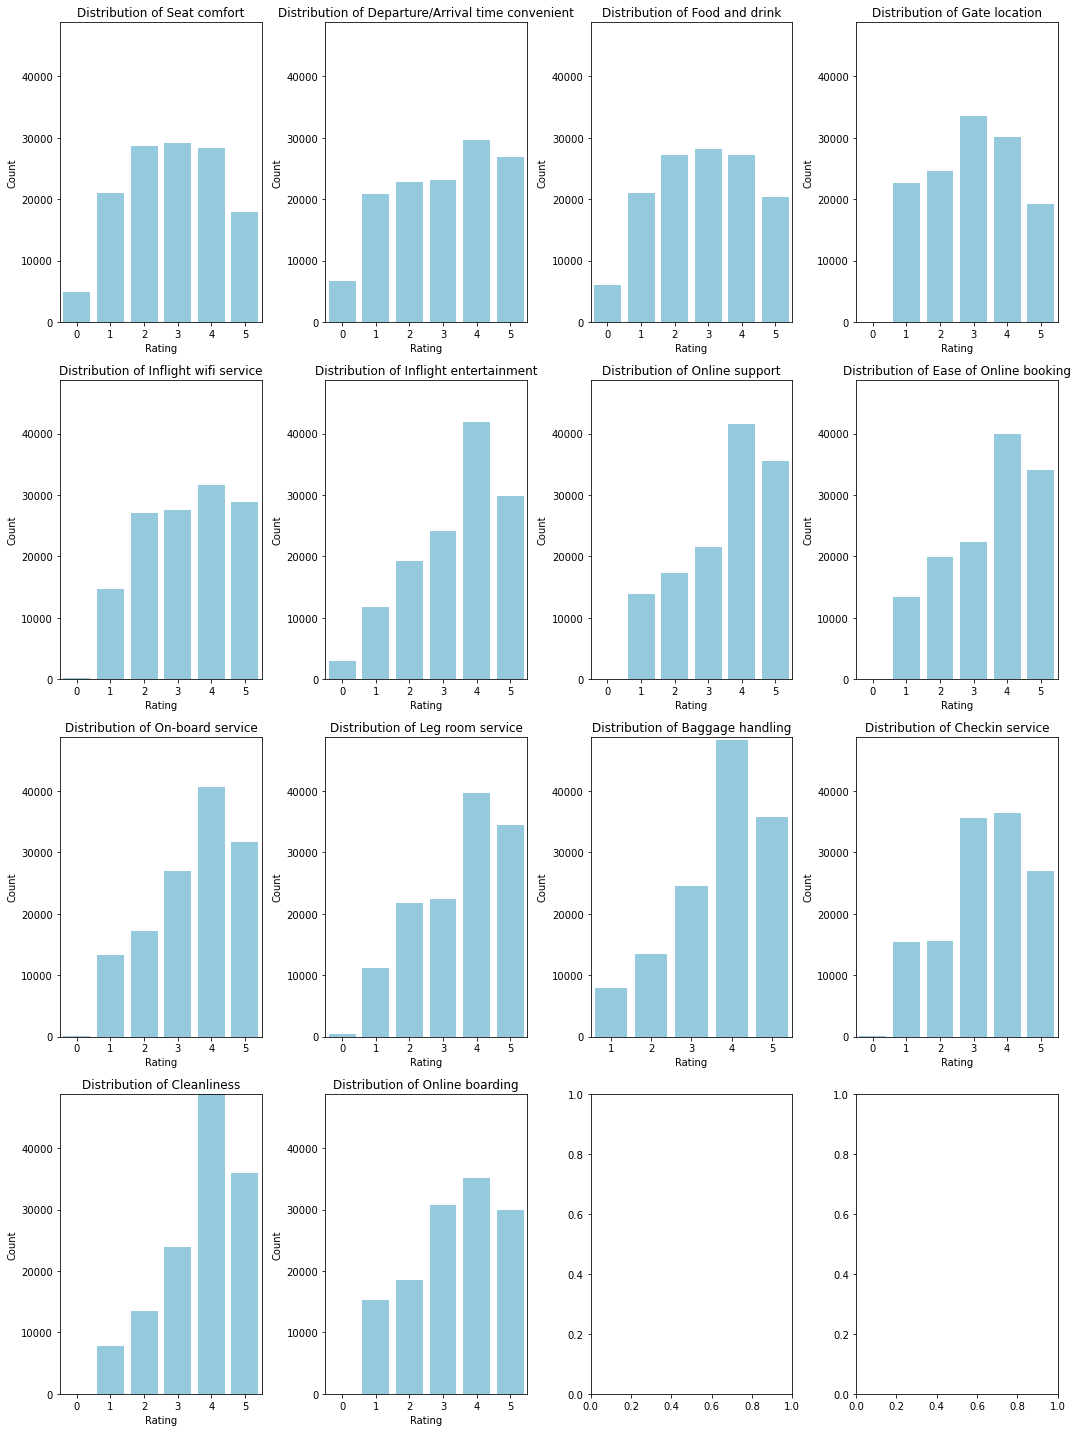

In [16]:
plot_features_bar(df, col_numr_rate, None, ['skyblue'], 4)

#### 0 Values

In [17]:
print('# 0s', '\t', '% Ft', '\t', 'Feature')
print()
for col in df[col_numr_rate]:
    zeros = len(df[df[col]==0])
    print(zeros, '\t', round(zeros/len(df)*100,2), '\t', col)

# 0s 	 % Ft 	 Feature

4797 	 3.69 	 Seat comfort
6664 	 5.13 	 Departure/Arrival time convenient
5945 	 4.58 	 Food and drink
2 	 0.0 	 Gate location
132 	 0.1 	 Inflight wifi service
2978 	 2.29 	 Inflight entertainment
1 	 0.0 	 Online support
18 	 0.01 	 Ease of Online booking
5 	 0.0 	 On-board service
444 	 0.34 	 Leg room service
0 	 0.0 	 Baggage handling
1 	 0.0 	 Checkin service
5 	 0.0 	 Cleanliness
14 	 0.01 	 Online boarding


In [18]:
mask = (df[col_numr_rate]==0).any(axis=1)
print(mask.sum()) # rows that will be dropped
print(round(mask.sum()/len(df)*100,2)) # proportion of entire dataset (%)

10269
7.91


#### 0s in Rating Features

The completeness of the dataset across rating question columns requires further examination since the scale runs from 0-5 (0,1,2,3,4,5). While 0 may seem like a valid response indicative of a very low score, the low proportion of 0s present within the features would pose a challenge to obtaining meaningful analysis. It is unclear whether 0s are meant to be actual scores, or whether they indicate a non-applicable response.

From here on, there are two possible ways to deal with these 0s. The first would be to remove them completely from the dataset - meaning to say that any row that contains a 0 response in any one feature column would be removed from the analysis. The total number of such rows that would be removed would be 10269, or ~8% of the dataset.

The next method would be to combine the 0 response with the 1 response. This would allow us to preserve ~8% of the data that would otherwise be removed. While we would then be able to derive analysis from a larger pool of responses, combining the 0s and 1s might possibly inflate the proportions of the 1-score in features in cases where there are many 0s. Although most features contain <2% of 0s, features such as inflight entertainment, food and drink, departure/arrival time convenience, and seat comfort, with more than >2% of 0s might end up seeing an unintended heightened proportion of 1s.

At this point, information is limited as to whether the 0s are a product of errors in the data collection process or actually intended to be present. As is, we will take the decision to remove rows that contain any 0s within the rating features since conducting analysis without distinguishing whether 0s represent an actual score or an irrelevant question would dilute the specificity of insights we later derive. Altering 0s to 1s may allow us to work with more data, but it is a marginal amount in comparison to the entire dataset. It is also an intervention at the edge of the 1-5 scale, which means that the effects of this would be more significant compared to if it were conducted in the middle.

In [19]:
df.drop(df[mask].index, inplace=True)

In [20]:
round(df[col_numr_rate].describe(),2).loc['mean'].sort_values(ascending=False)

Cleanliness                          3.72
Baggage handling                     3.71
Online support                       3.54
Leg room service                     3.52
Ease of Online booking               3.50
On-board service                     3.48
Inflight entertainment               3.47
Online boarding                      3.36
Checkin service                      3.33
Inflight wifi service                3.26
Departure/Arrival time convenient    3.13
Gate location                        3.00
Food and drink                       2.99
Seat comfort                         2.95
Name: mean, dtype: float64

#### Observations
After removing the 0s from the dataset, lets look at the mean scores across the rating features. 

The top three scoring ones regardless of satisfaction are:
1. Cleanliness (3.72)
2. Baggage handling (3.71)
3. Online support (3.54)

The lowest three scoring ones are:
1. Seat comfort (2.95)
2. Food and drink (2.99)
3. Gate location (3.00)

#### Exploratory analysis
These mean scores provide a quick first impression as to how the airline is performing for each feature. At this point, even without knowing which features are crucial to satisfaction, we can say that the airline should aim to keep up its service standards in cleanliness, baggage handling, and online support. On the other end, the airline could take a closer look into seat comfort, food and drink, and gate location.

Of course, it is important to acknowledge that the implications across cost, time and business impact differs across each metric. Negotiating with the airports to berth at more convenient gates, or overhauling an aircraft to upgrade seating comfort levels are both going to cost considerably more than upgrading food and drink options onboard.

From here on, we will further uncover drivers behind customer satisfaction, and couple them with an appreciation of the domain to form targetted and feasible recommendations.

### Feature Importance

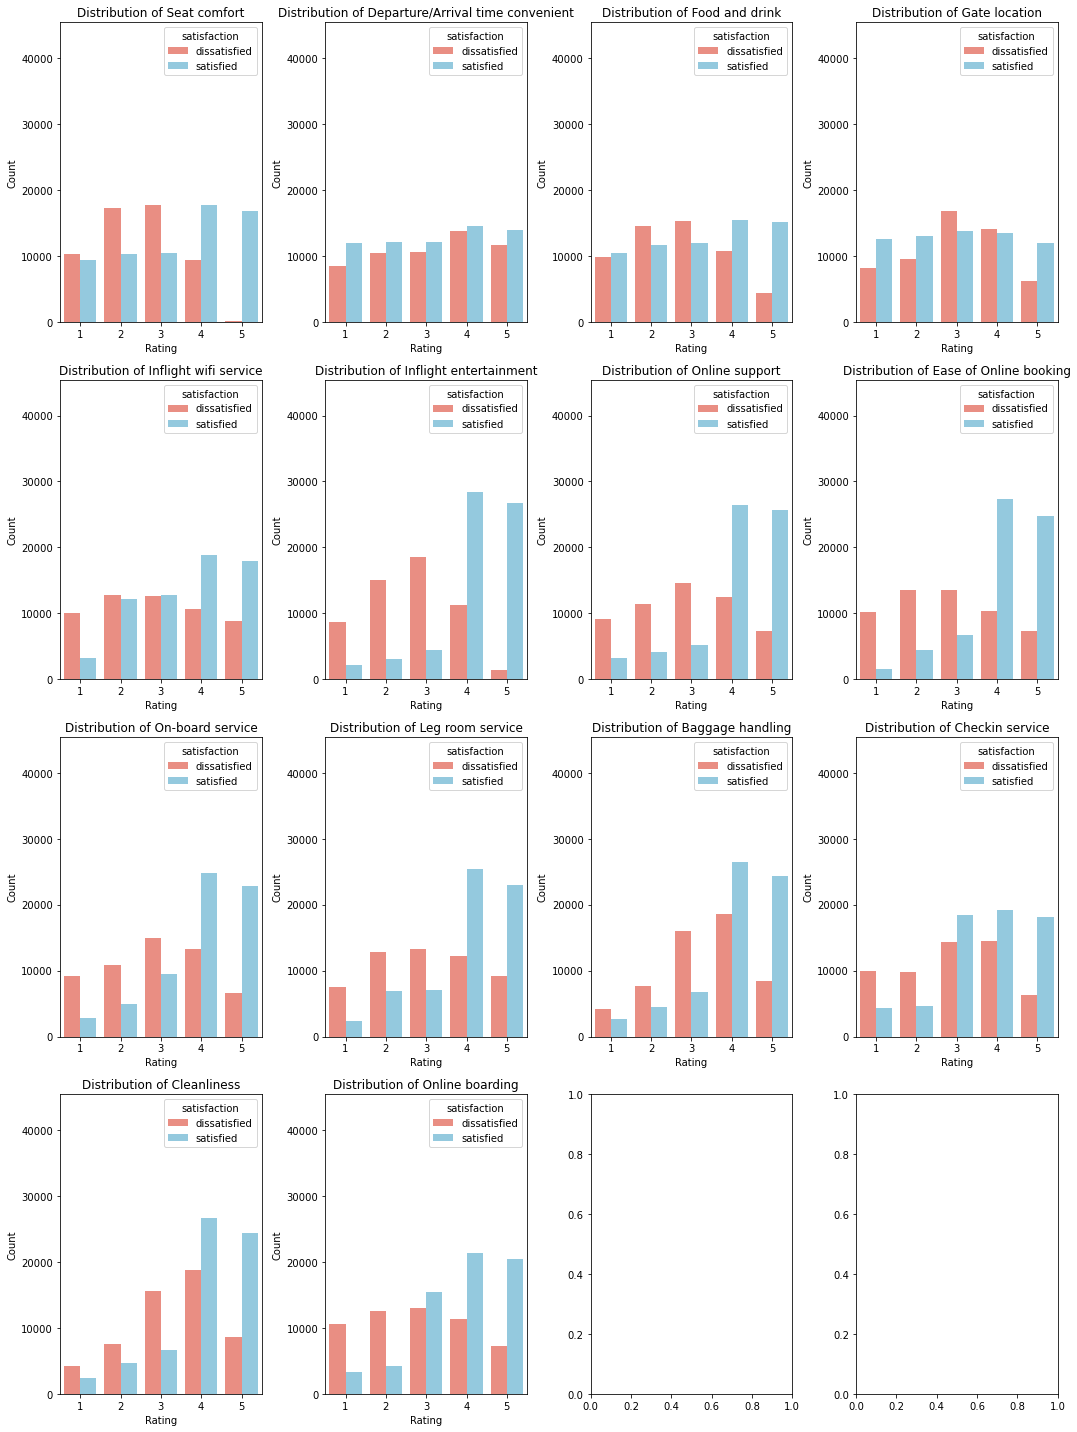

In [21]:
plot_features_bar(df, col_numr_rate, 'satisfaction', ['salmon', 'skyblue'], 4)

#### Cohen's d (effect size)

#### Cohen's d

Cohen's d is a standardized measure of effect size that quantifies the magnitude of the difference between two groups of satisfied and dissatisfied customers. We will use Cohen's d to further understand how differently satisfied and dissatisfied customers respond to the features in the dataset.

The interpretation of Cohen's d values can be categorized as follows:

Small Effect (Cohen's d around 0.2):

- A small effect size suggests that there is a noticeable difference between the two groups, but it may not be practically significant.
- The observed difference is present, but it might not have a substantial impact in real-world terms. It is important to consider whether the small effect size is practically meaningful in the context of the problem.

Medium Effect (Cohen's d around 0.5):

- A medium effect size indicates a moderate, noticeable difference between the groups.
- The observed difference is more substantial and may have practical significance.
- It suggests that the variable under consideration has a moderate impact on the groups being compared.

Large Effect (Cohen's d around 0.8 or higher):

- A large effect size suggests a substantial and impactful difference between the groups.
- The observed difference is strong and likely to have practical significance.
- It indicates that the variable being studied has a considerable impact on the groups being compared.

In [22]:
for feature in col_numr_rate:
    satisfied_ratings = df[df['satisfaction'] == 'satisfied'][feature]
    dissatisfied_ratings = df[df['satisfaction'] == 'dissatisfied'][feature]

    stat, p_value = mannwhitneyu(satisfied_ratings, dissatisfied_ratings)

    # Assess significance and interpret results
    if p_value < 0.05:
        print(feature)
        print("Significant difference")
    else:
        print(feature)
        print("No significant difference")
        
    effect_size = cohen_d(satisfied_ratings, dissatisfied_ratings)
    if abs(effect_size) > 0.8:
        size = '(Large)'
    elif abs(effect_size) > 0.5:
        size = '(Medium)'
    elif abs(effect_size) > 0.2:
        size = '(Small)'
    else:
        size = '(Very small)'
    
    print("Cohen's d:", round(effect_size,4), size)
    print()

Seat comfort
Significant difference
Cohen's d: 0.7129 (Medium)

Departure/Arrival time convenient
Significant difference
Cohen's d: -0.0538 (Very small)

Food and drink
Significant difference
Cohen's d: 0.3625 (Small)

Gate location
Significant difference
Cohen's d: -0.018 (Very small)

Inflight wifi service
Significant difference
Cohen's d: 0.5016 (Medium)

Inflight entertainment
Significant difference
Cohen's d: 1.4733 (Large)

Online support
Significant difference
Cohen's d: 0.9121 (Large)

Ease of Online booking
Significant difference
Cohen's d: 1.0719 (Large)

On-board service
Significant difference
Cohen's d: 0.8252 (Large)

Leg room service
Significant difference
Cohen's d: 0.7271 (Medium)

Baggage handling
Significant difference
Cohen's d: 0.6055 (Medium)

Checkin service
Significant difference
Cohen's d: 0.5734 (Medium)

Cleanliness
Significant difference
Cohen's d: 0.5995 (Medium)

Online boarding
Significant difference
Cohen's d: 0.7736 (Medium)



#### Top 3; Lowest 2

Here are the features with the largest effect size:
1. Inflight entertainment (1.4733)
2. Ease of Online booking (1.0719)
3. Online support (0.9121)

This suggests that improvements or attention to enhancing inflight entertainment options, simplifying online booking processes, and providing robust online support, could lead to increased overall customer satisfaction. 

As shown below, customers who rate Inflight entertainment, Ease of Online booking, and Online support 4 or 5 are most likely to be satisfied.

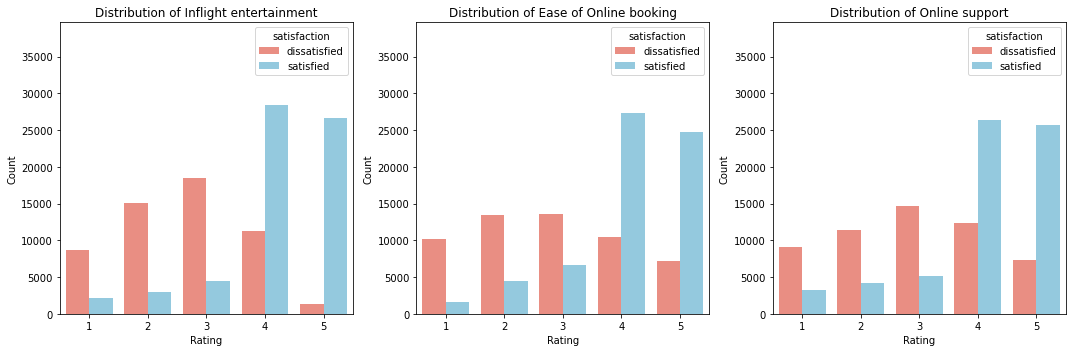

In [23]:
plot_features_bar(df, ['Inflight entertainment', 'Ease of Online booking', 'Online support'], 'satisfaction', ['salmon', 'skyblue'], 3)

And the two features with the smallest effect size:
1. Gate location (-0.018)
2. Departure/arrival time convenient (-0.0538)

In [24]:
mean_comp(df,'Gate location')

Gate location
Satisfied:	2.99
Dissatisfied:	3.01	 Diff: -0.02


In [25]:
mean_comp(df,'Departure/Arrival time convenient')

Departure/Arrival time convenient
Satisfied:	3.1
Dissatisfied:	3.17	 Diff: -0.07


A quick look into the mean values for satisfied/dissatisfied customers within the features Gate location and Departure/Arrival time convenience shows that both groups respond in a similar manner.

Earlier through the quick surveyance of average scores, we uncovered that Gate location and Departure/arrival time convenien(ce) were two of the lowest scoring features (on average). Yet, it seems that they do not have much effect on satisfaction. Perhaps these are two factors that customers acknowledge are difficult for the airline to control and improve - it is likely that customers acknowledge them as "nice to have", but not critical. At a later stage, it might be possible to exclude these features from the model to improve its performance.

### Bivariate Analysis

#### Travel Class and related features

Earlier we uncovered that customers travelling on Business Class tend to be more satisfied than those travelling on Eco or Eco Plus. While we intuitively know that travelling on Business Class offers an elevated experience across all flight services, an understanding of the differences between these two groups across the rating features may yield specific insights on how to improve customer satisfaction for customers travelling on Eco and Eco Plus.

As a start, let's examine two features that are intuitively distinct between travelling on Business and Economy: 
1. Seat comfort; seats in the Business class cabin are usually larger and more comfortable than in Eco.
2. Inflight entertainment; infotainment systems in Business are usually larger and more sophisticated than in Eco.

Eco


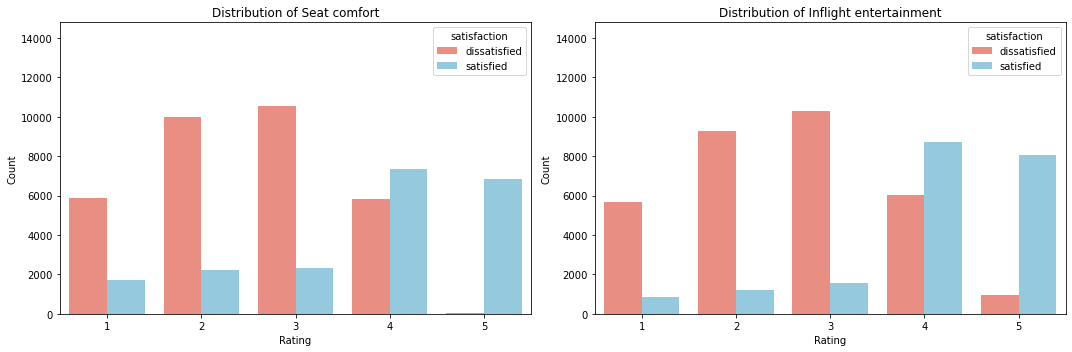


Business


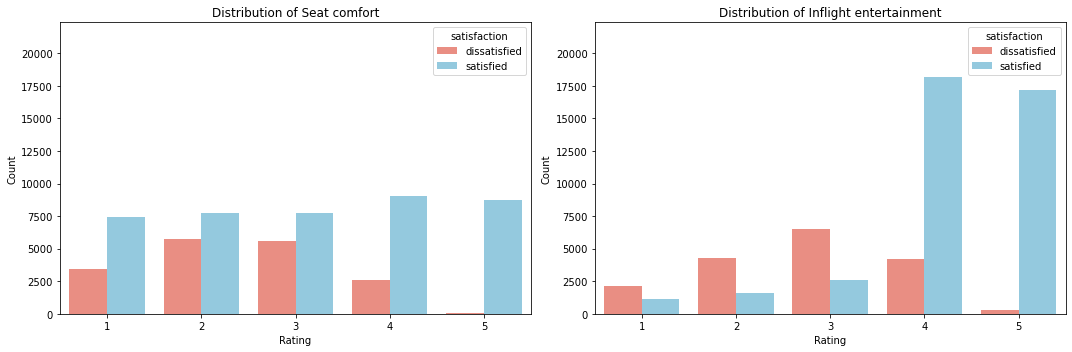


Eco Plus


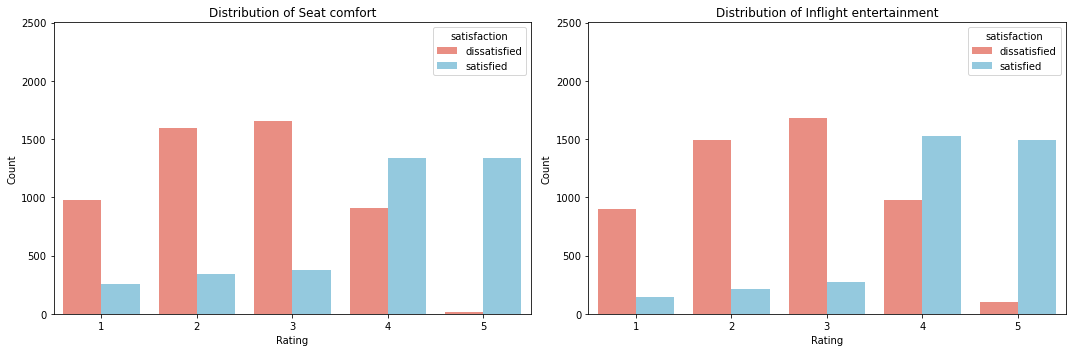

In [26]:
for tclass in df['Class'].unique():
    print(tclass)
    plot_features_bar(df[df['Class']==tclass], ['Seat comfort', 'Inflight entertainment'], 'satisfaction', ['salmon', 'skyblue'], 2)
    print()

#### Observations

Seat comfort 
- Most customers who score Seat comfort 4 or 5 tend to be satisfied. It is interesting to see that, across all travel Classes, a very small number of customers who rated 5 (maximum score) for Seat comfort turn out dissatisfied.

 - However, this is an exception within Business class. Satisfied customers travelling in Business do not tend to rate Seat comfort towards a particular direction. This suggests that the satisfaction of Business class customers might be determined elsewhere outside of Seat comfort. 

- Looking at how the responses change between scores 5 and 4, it is observed that only customers in Business class are the ones who mostly remain satisfied; customers travelling in Eco or Eco Plus who rated 4 for Seat comfort still tend to be satisfied, but by a smaller margin compared to customers travelling in Business class.

- Altogether, these observations seem to suggest that Seat comfort is an important feature for customers travelling in Eco or Eco Plus - more so than for customers travelling in Business class, where Seat comfort seems to have an established standard. A suggestion here would be to look for ways to improve Seat comfort in the Eco and Eco Plus cabin towards the standard of the Business class cabin.

Inflight entertainment
- Similar to Seat comfort, most customers who score Inflight entertainment 4 or 5 tend to be satisfied. Across all travel Classes, a very small number of customers who rated 5 (maximum score) for Inflight entertainment turn out dissatisfied.

- Moving down to the next lower score of 4, it is observed that only customers in Business class are the ones who still remain mostly satisfied; customers travelling in Eco or Eco Plus who rated 4 for Inflight entertainment still tend to be satisfied, but by a smaller margin compared to customers travelling in Business class.

- This seems to suggest that Inflight entertainment services within the Business class cabin is a strong driver of satisfaction. A strong Inflight entertainment service offering in Business class seems to be reflected in the form of high ratings and high levels of satisfaction.

- An different deduction for satisfaction can be made in Eco and Eco Plus customers. While these customers who rate Inflight entertainment 4 or 5 tend to be satisfied, customers who rate 1 to 3 tend to be dissatisfied.

- Altogether, it seems like there is a distinction between the Inflight entertainment services offered in Business and Eco and Eco Plus. A suggestion here would be to ensure consistency in the Business class' Inflight entertainment offer, and look for ways to improve what is offered in Eco and Eco Plus.



## Non-rating Features

### Distributions

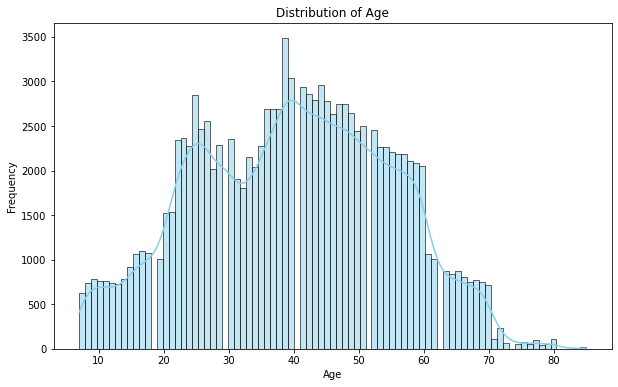

In [27]:
# Assuming 'Departure Delay in Minutes' is the column name in your DataFrame
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=df['Age'].max(), kde=True, color='skyblue')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')

# Show the plot
plt.show()

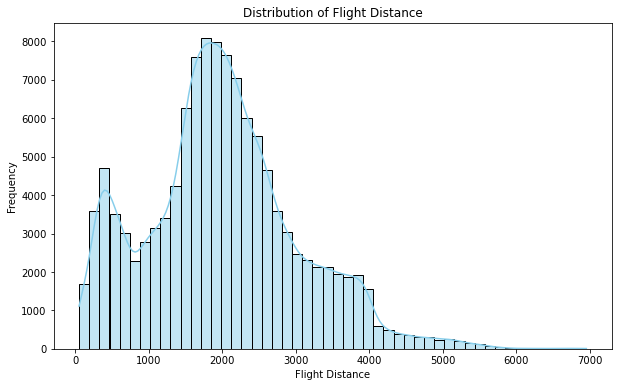

In [28]:
# Assuming 'Departure Delay in Minutes' is the column name in your DataFrame
plt.figure(figsize=(10, 6))
sns.histplot(df['Flight Distance'], bins=50, kde=True, color='skyblue')

# Add labels and title
plt.xlabel('Flight Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Flight Distance')

# Show the plot
plt.show()

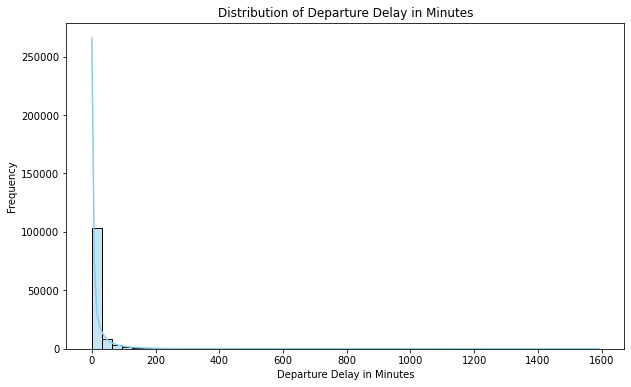

In [29]:
# Assuming 'Departure Delay in Minutes' is the column name in your DataFrame
plt.figure(figsize=(10, 6))
sns.histplot(df['Departure Delay in Minutes'], bins=50, kde=True, color='skyblue')

# Add labels and title
plt.xlabel('Departure Delay in Minutes')
plt.ylabel('Frequency')
plt.title('Distribution of Departure Delay in Minutes')

# Show the plot
plt.show()

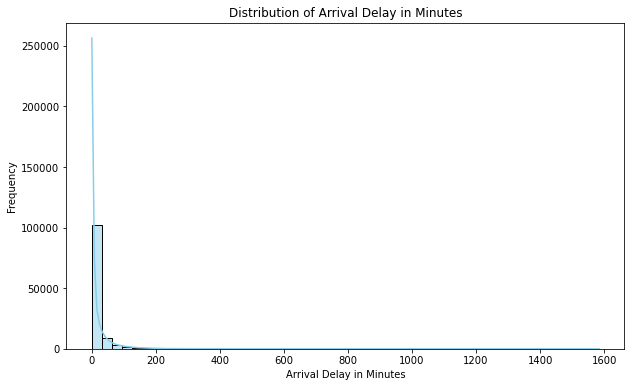

In [30]:
# Assuming 'Departure Delay in Minutes' is the column name in your DataFrame
plt.figure(figsize=(10, 6))
sns.histplot(df['Arrival Delay in Minutes'], bins=50, kde=True, color='skyblue')

# Add labels and title
plt.xlabel('Arrival Delay in Minutes')
plt.ylabel('Frequency')
plt.title('Distribution of Arrival Delay in Minutes')

# Show the plot
plt.show()

In [31]:
df['Departure Delay in Minutes'].corr(df['Arrival Delay in Minutes'])

0.96504719237807

#### NULL Values

There are a small number of null values present in the Arrival Delay in Minutes column. There is a similar column in Departure Delay in Minutes which is complete.

Given that the correlation between the two columns is very high (0.965), it would be possible to remove the Arrival Delay in Minutes column from the analysis. A lower number of features would allow the model to be explained clearer.

In [32]:
df.drop('Arrival Delay in Minutes', axis=1, inplace=True)
col_numr_nonrate.remove('Arrival Delay in Minutes')

#### Violin Plots

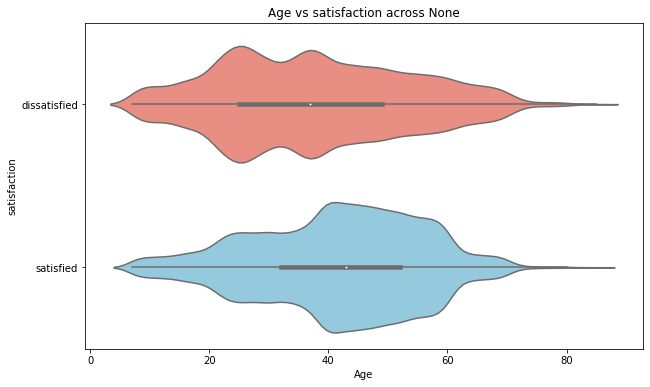

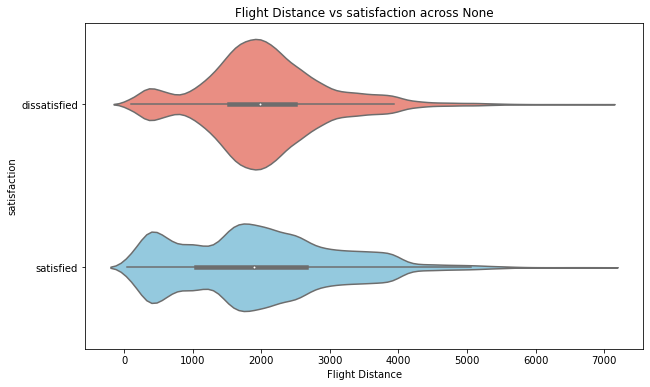

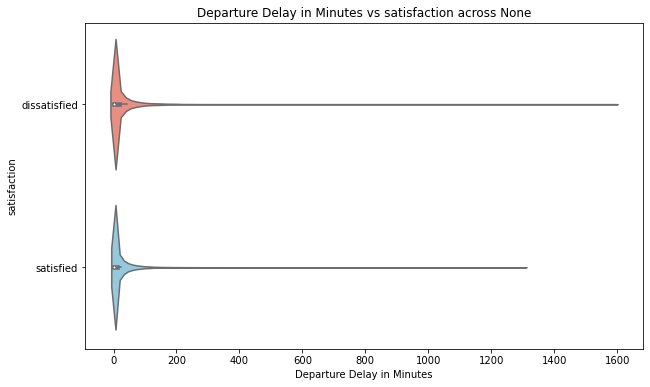

In [33]:
plot_violin(df, 'Age', 'satisfaction', None, ['salmon', 'skyblue'])
plot_violin(df, 'Flight Distance', 'satisfaction', None, ['salmon', 'skyblue'])
plot_violin(df, 'Departure Delay in Minutes', 'satisfaction', None, ['salmon', 'skyblue'])

#### Observations

Chart 1 - Satisfaction across Age

- In general, it appears that customers who are older tend to be more satisfied than younger customers. 
- A large portion of dissatisfied customers fall between 20-40 years of age. Conversely, a large portion of satisfied customers fall between 40-60 years of age.

Chart 2 - Satisfaction across Flight Distance

- It appears that customers travelling to destinations ~2000nm (nm for nautical miles; actual units unknown) are generally dissatisfied.

Chart 3 - Satisfaction across Departure Delay by Minutes

- Deriving any observations from this chart is difficult since the data is heavily skewed to the right. Most of the flights record Departure Delays around 0-120 minutes, yet there are extreme outliers with delays far exceeding 120 minutes. 
- It might be possible to transform the Departure Delays into a categorical feature (Negligible delay, acceptable delay, some delay, medium delay, high delay, etc.) or scale it logarithmically to reduce the effects of outliers before putting it through further bivariate analyses.

### Bivariate Analysis

#### Age

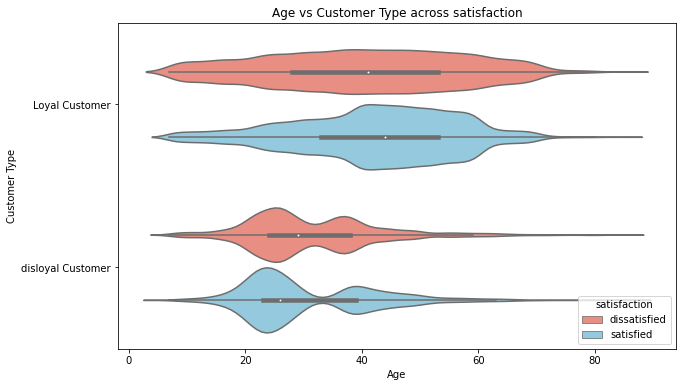

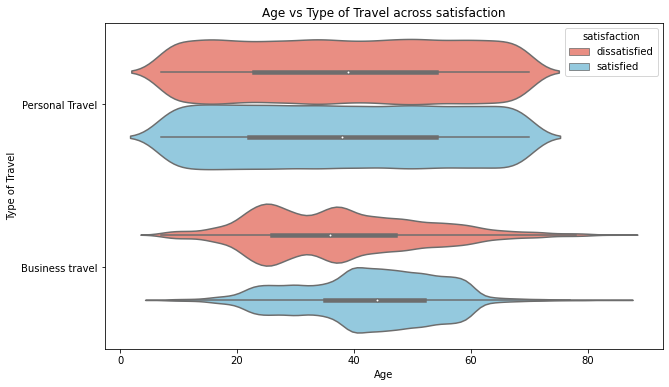

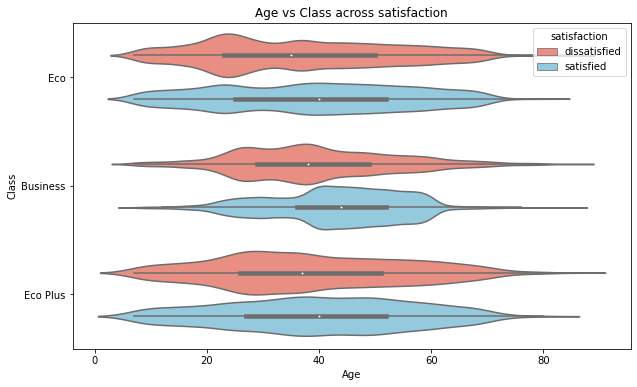

In [34]:
plot_violin(df, 'Age', 'Customer Type', 'satisfaction', ['salmon', 'skyblue'])
plot_violin(df, 'Age', 'Type of Travel', 'satisfaction', ['salmon', 'skyblue'])
plot_violin(df, 'Age', 'Class', 'satisfaction', ['salmon', 'skyblue'])

Chart 1 - Satisfaction across Age, separated by Customer Type

- The Age of a Loyal customer seems to affect satisfaction.

- Dissatisfied customers who are Loyal do not seem to be confined to a particular age group. However, the Age of Satisfied customers who are Loyal see concentrated seem to fall between 40-60.

- Dissatisfied and Satisfied customers who are Disloyal are smaller groups. However, they do not seem too distinct from each other across all Age groups.

Chart 2 - Satisfaction across Age, separated by Type of Travel

- The Age of a customer travelling for Business seems to affect satisfaction.

- The Age of Dissatisfied customers travelling for Business appears to fall between 20-40. However, the Age of Satisfied customers travelling for Business appears to fall between 40-60.

- Dissatisfied and Satisfied customers who are travelling for Personal reasons do not seem too distinct from each other across all Ages.

Chart 3 - Satisfaction across Age, separated by Class

- The Age of a customer travelling in Eco or Business seems to affect satisfaction.

- Dissatisfied and Satisfied customers who are travelling on Eco see a small distinction across the Ages between 20-30. Customers in that Age group who are travelling on Eco tend to be Dissatisfied. This effect is also observed in customers travelling in Eco Plus, although we must remember that Eco Plus travellers form a small group of customers.

- An opposite but more distinct effect can be seen in customers travelling on Business. The Age of Dissatisfied customers travelling on Business appears to fall between 20-40. However, the Age of Satisfied customers travelling for Business appears to fall between 40-60.

#### Flight Distance

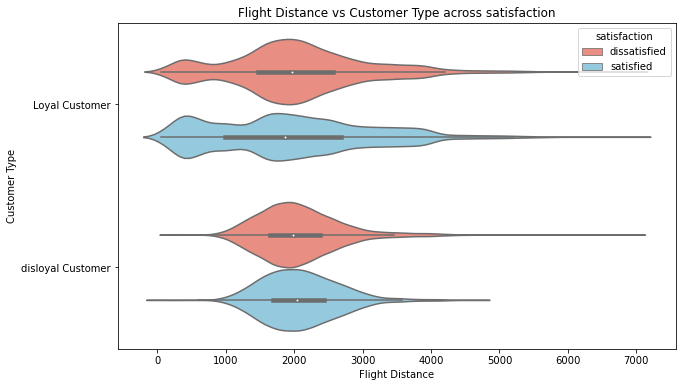

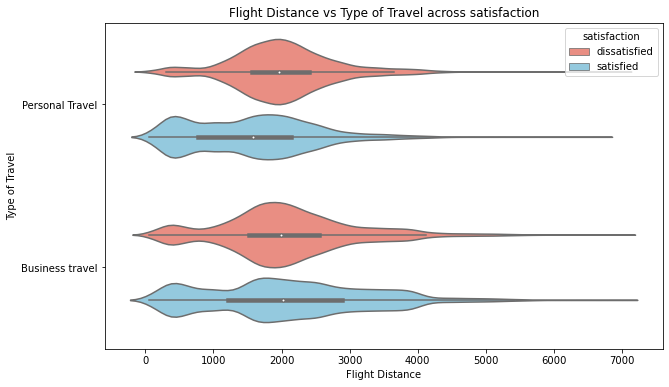

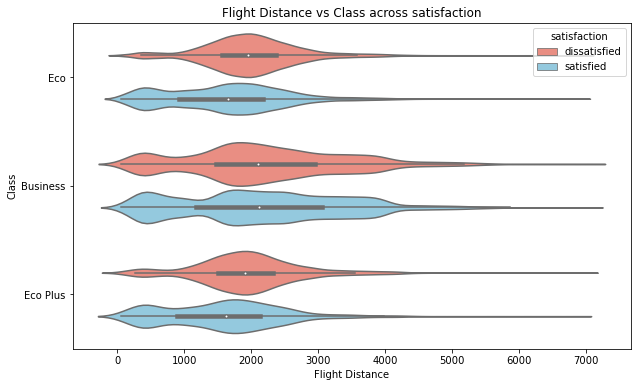

In [35]:
plot_violin(df, 'Flight Distance', 'Customer Type', 'satisfaction', ['salmon', 'skyblue'])
plot_violin(df, 'Flight Distance', 'Type of Travel', 'satisfaction', ['salmon', 'skyblue'])
plot_violin(df, 'Flight Distance', 'Class', 'satisfaction', ['salmon', 'skyblue'])

#### Observations

Chart 1 - Satisfaction across Flight Distance, separated by Customer Type

- The Flight Distance travelled by a Loyal customer seems to affect satisfaction, although we earlier uncovered that there are a lot more Loyal customers than Disloyal ones.

- Loyal customers tend to be dissatisfied when travelling on flights ~2000nm.  

Chart 2 - Satisfaction across Flight Distance, separated by Type of Travel

- The Flight Distance travelled by a customer for Personal or Business reasons do not seem to affect satisfaction.

- In general, for both Personal and Business travel, customers on short distance flights (<1200nm) seem to be more satisfied than when Flight Distances approach ~2000nm.

Chart 3 - Satisfaction across Flight Distance, separated by Class

- The Flight Distance travelled by a customer in Business/Eco/Eco Plus seems to affect satisfaction.

- In general, for both all 3 travel Classes, customers on short distance flights (<1200nm) seem to be more satisfied. This is especially true for passengers travelling on Eco/Eco Plus.

# Data Modelling

## Data Pre-processing

In [36]:
X = df.drop("satisfaction", axis=1)
y = df["satisfaction"]

In [37]:
# One hot Endocing .
X = pd.get_dummies(X, columns=['Class'])

# Label Encoding.
label_encoder = LabelEncoder()
for i in ['Customer Type', 'Type of Travel']:
    X[i] = label_encoder.fit_transform(X[i])

In [38]:
# Select the features you want to scale
selected_features = X[["Age", "Flight Distance", "Departure Delay in Minutes"]]

# Create a scaler object.
scaler = StandardScaler()

# Fit scaler on the selected features.
scaler.fit(selected_features)

# Transform the selected features with the scaler.
selected_features_scaled = scaler.transform(selected_features)

# Replace the original columns with the scaled values in the DataFrame
X[["Age", "Flight Distance", "Departure Delay in Minutes"]] = selected_features_scaled

X.head()

,Customer Type,Age,Type of Travel,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,...,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Class_Business,Class_Eco,Class_Eco Plus
1037,0,0.541876,1,1.931914,1,1,1,1,1,1,...,4,1,1,4,2,1,0.028803,0,1,0
1038,0,0.541876,1,1.911688,1,1,1,1,4,1,...,2,3,2,3,2,4,-0.388919,0,1,0
1041,0,0.009568,1,0.246396,1,1,1,1,1,1,...,3,3,2,1,1,1,-0.388919,0,1,0
1043,0,0.408799,1,0.440953,1,1,1,1,3,1,...,1,4,1,2,2,3,-0.310596,0,1,0
1044,0,1.539952,1,0.015239,1,1,1,1,5,1,...,1,5,2,1,2,5,0.263772,0,1,0


## Model Selection

In [39]:
# Define a list of models to evaluate
models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(),
    RandomForestClassifier() 
]

In [40]:
# Split train data into train and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Iterate over each model and evaluate its accuracy using cross-validation.
for model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5)
    
    # Print the mean accuracy score for the current model
    print(f"{model.__class__.__name__}: Mean Accuracy = {round(scores.mean(),3)}")

LogisticRegression: Mean Accuracy = 0.86
DecisionTreeClassifier: Mean Accuracy = 0.932
RandomForestClassifier: Mean Accuracy = 0.954


## Random Forest Model (Classification)

In [41]:
# Step 1: Split the dataset into training and temporary (validation + test) sets
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2: Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [42]:
# Step 3: Train the model on the training set
model = RandomForestClassifier()
model.fit(X_train_temp, y_train_temp)

RandomForestClassifier()

In [43]:
# Step 4: Test the model on the test set
y_test_pred = model.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)
print(f"Baseline Test Accuracy: {acc_test:.3f}")

Baseline Test Accuracy: 0.953


In [51]:
# Assuming y_true and y_pred are your actual and predicted labels, respectively
y_true = df['satisfaction']  # Replace 'satisfaction' with the actual column name
y_pred = model.predict(X)  # Assuming you have already trained and fitted your model on the training set

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)
print()

# Compute other metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, pos_label='satisfied')  # Specify the positive class label
recall = recall_score(y_true, y_pred, pos_label='satisfied')
f1 = f1_score(y_true, y_pred, pos_label='satisfied')

# Print other metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Confusion Matrix:
[[54188   667]
 [ 1023 63733]]

Accuracy: 0.99
Precision: 0.99
Recall: 0.98
F1-Score: 0.99


Confusion Matrix:
- True Positives (TP): 63,733
- True Negatives (TN): 54,188
- False Positives (FP): 667
- False Negatives (FN): 1,023

Accuracy:

- Accuracy is the proportion of correctly classified instances among the total instances.
- In this case, accuracy is 99%, suggesting that your model is accurate in predicting both satisfied and dissatisfied instances.

Precision:
- Precision is the proportion of true positive predictions among the total predicted positives.
- A precision of 99% indicates that when the model predicts 'satisfied,' it is correct 99% of the time.

Recall (Sensitivity):
- Recall is the proportion of true positive predictions among the total actual positives.
- A recall of 98% indicates that your model is capturing 98% of the actual 'satisfied' instances.

F1-Score:
- The F1-Score is the harmonic mean of precision and recall, providing a balance between the two.
- An F1-Score of 99% suggests a good balance between precision and recall.

### Explaining the Model

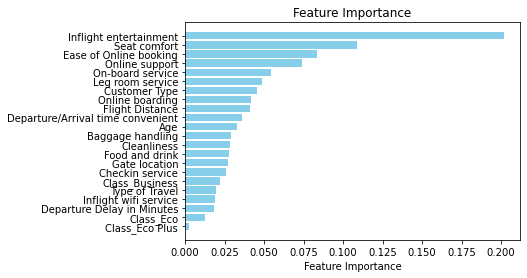

In [44]:
# Get feature importances
feature_importance = model.feature_importances_

# Sort feature importance indices
sorted_idx = np.argsort(feature_importance)

# Retrieve feature names
features = X.columns

# Display feature importance
plt.figure()
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color='skyblue')
plt.yticks(range(len(sorted_idx)), features[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.show()

#### Explaining the Model

- Inflight entertainment is a feature that contributes the most predictive power to the model. 
- The next few standout features are: Seat comfort, Ease of Online booking, Online support.
- Interestingly, Eco and Eco Plus are the lowest two features in terms of predictive power contributed. It is possible that the impact of travel Classes is better expressed through other features such as Inflight entertainment and Seat comfort - which we uncovered earlier in the bivariate analysis.

#### Recommendations

According to the model, 5 areas to allocate resources towards would be:

1. Inflight entertainment
2. Seat comfort
3. Ease of Online booking
4. Online support
5. Leg room service

To streamline the recommendations, these 5 areas can be funnelled down to 3:

1. Inflight entertainment
2. Inflight seating (Seat comfort + Leg room service)
3. Online customer experience (Ease of Online booking + Online support)

Inflight entertainment

- Echoing our exploratory analysis conducted earlier, the airline should continue the excellent service provided in the Business class cabin. The Inflight entertainment systems in Eco and Eco Plus cabins seem to be a strong determinant to satisfaction levels, and should be improved towards a standard close to what is offered in Business class.

- Considering areas in hardware and software allows different solutions to be developed in consideration to budget and time constraints. A hardware upgrade or overhaul would be more time consuming and costly compared to a software upgrade.

Inflight Seating (Seat Comfort + Leg Room Service)

- Seat comfort and leg room service collectively contribute to the overall inflight seating experience. These aspects are crucial for passenger satisfaction, especially for longer flights where dissatisfaction becomes more common for passengers travelling in Eco and Eco Plus.

- Customer feedback on these specific elements should be considered to more specifically identify pain points and areas for improvement.

- Though as a start, the airline could explore options like upgrading seat cushions or offering additional amenities such as pillows or blankets that might improve Seat comfort. 

- Improving Leg room service could involve optimizing the seating layout or exploring new models of seat that may be more minimalistic.

Online Customer Experience (Ease of Online Booking + Online Support)

- A seamless online booking process and efficient online support services contribute to a positive overall online customer experience.

- Ensuring a streamlined booking interface, clarity in the booking steps, and providing a responsive customer support system has the potential to enhance satisfaction.

### Tuning the Model

In [47]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Step 5: Tune the model using RandomizedSearchCV
param_dist = {'n_estimators': randint(50, 200), 
              'max_depth': [None, 10, 20, 30], 
              'min_samples_split': randint(2, 10), 
              'min_samples_leaf': randint(1, 4)}

random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist, n_iter=10, cv=5)
random_search.fit(X_train_temp, y_train_temp)

# Obtain the best hyperparameters
best_params_random = random_search.best_params_

# Step 6: Re-train the tuned model on the training set
tuned_model_random = RandomForestClassifier(**best_params_random)
tuned_model_random.fit(X_train_temp, y_train_temp)

Tuned Validation Accuracy (Randomized Search): 0.953


In [49]:
best_params_random

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 170}

In [48]:
# Step 7: Validate the tuned model on the validation set
y_val_pred_random = tuned_model_random.predict(X_val)
acc_val_random = accuracy_score(y_val, y_val_pred_random)
print(f"Tuned Validation Accuracy (Randomized Search): {acc_val_random:.3f}")

Tuned Validation Accuracy (Randomized Search): 0.953


#### Model Performance after Tuning

The accuracy score for the model is the same after tuning. It performs well on new data that it has not been exposed to. This suggests that the model is likely to be robust and not overfitting to the training data.

From here on, the model can be redeployed to new data to validate whether improvements made by the airline have resulted in increased satisfaction.